<a href="https://colab.research.google.com/github/heosooyoun/LLM/blob/main/chap3_4_%EA%B0%80%EC%A4%91%EC%B9%98_%EC%97%86%EB%8A%94_%EC%96%B4%ED%85%90%EC%85%98%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chpter3. 어텐션 매커니즘 구현하기**

In [13]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

# 어텐션 점수 계산하기
query = inputs[1] # 두번째 입력을 쿼리라고 가정

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
    # 점곱 (1차원 벡터이므로 전치가 필요 없습니다)

print(attn_scores_2)

# 정규화 되지 않은 어텐션 점수를 합이 1이 되도록 정규화
attn_weights_2_temp = attn_scores_2 / attn_scores_2.sum()
print("어텐션 가중치: ", attn_weights_2_temp)
print("합: ", attn_weights_2_temp.sum())

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
어텐션 가중치:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
합:  tensor(1.0000)


점곱 예시

[0.43, 0.15, 0.89]
[0.55, 0.87, 0.66]

이 두 벡터의 각 요소들을 각각 곱하고 더한 것

(0.43 * 0.55) + (0.15 * 0.87) + (0.89 * 0.66)

In [14]:
# 보통 실전에서는 소프트맥스 함수로 정규화 하는것이 일반적 + 권장
# 아래는 단순 소프트맥스 함수 구현
def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum(dim=0) #exp(): 지수함수를 적용

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("어텐션 가중치:", attn_weights_2_naive)
print("합:", attn_weights_2_naive.sum())

attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("어텐션 가중치:", attn_weights_2)
print("합:", attn_weights_2.sum())


어텐션 가중치: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
합: tensor(1.)
어텐션 가중치: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
합: tensor(1.)


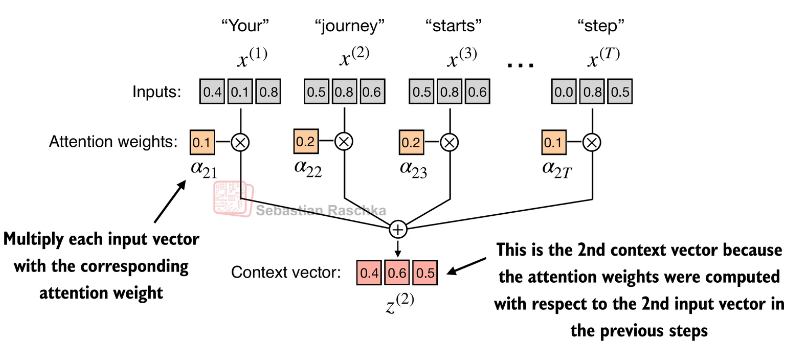

어텐션 가중치: 두 벡터가 얼마나 가까운지  => 점수가 높으면 두 벡터 사이의 관계가 가깝다

어텐션 가중치 * 입력벡터(벨류) = 모두 더하면 문맥 벡터

In [15]:
#임베딩된 입력토큰과 어텐션 가중치를 곱하고 결과 벡더를 더해 문맥 벡터를 계산

query = inputs[1]
context_vec_2 = torch.zeros(query.shape)

for i, x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i]


print(context_vec_2)

tensor([1., 1., 1.])


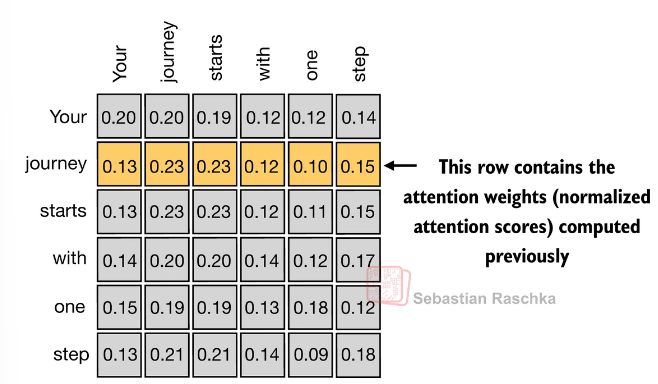

모든 입력은 쿼리 토큰이 될 수 있음 => 어텐션 가중치가 6 * 6 = 36개

In [16]:
attn_scores = torch.empty(6, 6)

for i, x_i in enumerate(inputs): # 모든 입력벡터가 쿼리 토큰이 됌
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j) # 모든 입력을 점곱

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [17]:
# 행렬 곱셈으로 더 효율적인 계산 가능
# [6,3] 크기의 입력을 역치해서 [3,6] 두개를 행렬 곱셈
# [6,3]@[3,6] = [6,6]
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [18]:
# softmax를 이용해 정규화
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

# 문맥벡터 계산
all_context_vecs = attn_weights @ inputs # [6,6] @ [6,3] = [6,3]
print(all_context_vecs)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])
tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
